# Week Two
---
- logistic回归
- 使用numpy对计算向量化

## 二分类器-logistics回归

分类器的预测值是$P(\hat{Y}=1|x)$, 使得概率尽可能与实际标签相符.logistics回归使用logit模型将$W^TX+b$映射到0-1, 以下表达式也称为sigmoid函数
$$\sigma(z) = \frac{1}{1+e^{-z}}$$
> sigmoid函数的求导特点:$\sigma\prime(z) = \sigma(z)(1-\sigma(z))$

**loss函数**: 评价预测值与真实值之间的差距
$$L(\hat{y}, y)=-(ylog\hat{y}+(1-y)log(1-\hat{y}))$$
> 为什么要使用交叉熵而不使用方差作为loss函数?
传统回归方法可以采用MSE方法, 当采用sigmoid函数做分类时, MSE方法对W和b的求导与simoid函数的导数有关, 在两侧sigmoid导数小, 下降慢, 但是采用CrossEtropy时, loss函数对W和b的导数只与$\hat{y}-y$相关, 具有更好的下降性质, 其他回归采用MSE方法可行的原因是预测函数性质不同, 不具有sigmoid的性质. 详见[交叉熵](https://zhuanlan.zhihu.com/p/61944055). Andrew也给出另一方面的解释, MSE是非凸函数,其在使用梯度下降算法时容易陷入局部最优解, 因此这里要采用凸函数.

**Cost函数**:以当前的W和b参数进行预测产生的成本,即平均loss
$$J(W, b) = \frac{1}{m} \sum_{i} L(\hat{y_i}, y_i)$$

**推导计算与反向传播**

正向计算是从输入到输出的计算过程, 反向传播使用链式法则, 对W和b的每一维求J的偏导
![](src/pictures/c1_w1_1.png)

在LR中,参数的反向传播推导略,结果为
$$dw = \frac{1}{m}\sum_{i}^{m}(A_i - Y_i)X_i \\ db = \frac{1}{m}\sum_{i}^{m}A_i - Y_i$$

## numpy中的广播机制

- 如果两个数组的后缘维度的轴长度相符或其中一方的轴长度为1，则认为它们是广播兼容的。广播会在缺失维度和轴长度为1的维度上进行。
- 后缘维度的轴长度：A.shape[-1] 即矩阵维度元组中的最后一个位置的值
- 虽然在Python有广播的机制，但是在Python程序中，为了保证矩阵运算的正确性，可以使用reshape()函数来对矩阵设定所需要进行计算的维度，这是个好的习惯；

    如果用下列语句来定义一个向量，则这条语句生成的a的维度为（5，），既不是行向量也不是列向量，称为秩（rank）为1的array，如果对a进行转置，则会得到a本身，这在计算中会给我们带来一些问题。
    ```python
    a = np.random.randn(5)
    ```
    如果需要定义（5，1）或者（1，5）向量，要使用下面标准的语句：
    ```python
    a = np.random.randn(5,1)
    b = np.random.randn(1,5)
```
- 可以使用assert语句对向量或数组的维度进行判断。assert会对内嵌语句进行判断，即判断a的维度是不是（5，1），如果不是，则程序在此处停止。使用assert语句也是一种很好的习惯，能够帮助我们及时检查、发现语句是否正确。

- 可以使用reshape函数对数组设定所需的维度
```python
a.reshape((5,1))
```

In [28]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X, y = load_digits(2, True)
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size = 0.3)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [35]:
def sigmoid(x):
    '''
    返回X的sigmoid函数值
    x -- scale or numpy Array
    '''
    return 1./(1 + np.exp(-x))
def normalize(x):
    '''
    将x标准化至0-1
    '''
    x_norm = np.linalg.norm(x, axis = 1, keepdims=True) # 计算array的行norm值
    return x / x_norm

def propagate(w, b, x, y):
    '''
    正反向传播的计算,返回正向的cost和反向的梯度
    w--weights,(n, 1)
    b--bias, 1
    X--features,(m, n)
    y--labels,(m, 1)
    m-number of samples
    n-dim of features
    Return:
    grads--gradients, dict
    cost--array, ()
    '''
    m = x.shape[0]
    z = x.dot(w) + b # (m, 1)
    a = sigmoid(z)
    dz = a - y
    dw = (1./m) * x.T.dot(dz)
    db = (1./m) * np.sum(dz)
    cost = - (1./m) * (y.T.dot(np.log(a)) + (1-y).T.dot(np.log(1-a)))
    cost = np.squeeze(cost) # 降维(1,1)->() 
    grads = {'dw':dw,
           'db':db}
    return grads, cost

def initialize_with_zero(dim):
    '''
    用0初始化权重和偏置
    dim-number of features
    Return: parameters of dim and bias
    '''
    w = np.zeros((dim, 1))
    b = 0
    return w, b

def optimize(w, b, X, Y, num_of_iterations, learning_rate, print_costs = False):
    costs = []
    for i in range(num_of_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads['dw']
        db = grads['db']
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if print_costs and i%100 == 0:
            print("cost after iteration:%d is %f" % (i, cost))
        costs.append(cost)
    params = {"W":w, "b":b}
    grads = {"dw":dw, "db":db}
    return params, grads, costs

def predict(X, params):
    W = params['W']
    b = params['b']
    z = sigmoid(np.dot(X, W) + b)
    y_p = [1 if i > 0.5 else 0 for i in z]
    y_p = np.array(y_p).reshape(z.shape)
    return y_p

In [41]:
W, b = initialize_with_zero(X_train.shape[1])
params, grads, costs = optimize(W, b, X_train, y_train, 1000, 0.01, True)

cost after iteration:0 is 0.693147
cost after iteration:100 is 0.005252
cost after iteration:200 is 0.002916
cost after iteration:300 is 0.002043
cost after iteration:400 is 0.001580
cost after iteration:500 is 0.001292
cost after iteration:600 is 0.001094
cost after iteration:700 is 0.000950
cost after iteration:800 is 0.000840
cost after iteration:900 is 0.000753


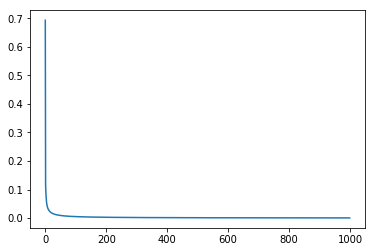

In [42]:
plt.plot(range(len(costs)), costs)

In [43]:
y_p = predict(X_test, params)

In [44]:
np.sum(np.abs(y_test - y_p))

0